# Предсказание сердечно-сосудистых заболеваний

Импорт библиотек, скачивание датасета: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

In [580]:
!pip install kagglehub

In [581]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from IPython.display import display
import shutil
import os


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

if not os.path.exists('dataset'):
    path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")
    work_dir = os.getcwd()

    os.rename(path, 'dataset')

    print("Path to dataset files:", path)
    print("Path to work directory", work_dir)

## EDA

### Признаки:
**age**: возраст (дни) int \
**height**: рост (см) int  \
**weight**: вес (кг) float  \
**gender**: пол (бинарный признак) int  \
**ap_hi**: верхнее артериальное давление int  \
**ap_lo**: нижнее артериальное давление int  \
**cholesterol**: холестерин (1: в норме, 2: выше нормы, 3: значительно выше нормы) int  \
**gluc**: глюкоза (1: в норме, 2: выше нормы, 3: значительно выше нормы) int  \
**smoke**: Курение (бинарный признак) int  \
**alco**: Употребление алкоголя (бинарный признак) int  \
**active**: Физическая активность (бинарный признак) int  \
**cardio**: Наличие или отсутствие сердечно-сосудистых заболеваний (целевая переменная, бинарная) int  

столбец id бесполезен для обучения модели

In [582]:
df = pd.read_csv('.\dataset\cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [583]:
df.shape

(70000, 13)

В данных нет дисбаланса классов

In [584]:
df['cardio'].value_counts()

cardio
0    35021
1    34979
Name: count, dtype: int64

В данных нет дубликатов

In [585]:
df.duplicated().sum().sum()

np.int64(0)

В данных нет пропусков, все признаки целочисленные/дробные

In [586]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


признаки ap_hi и ap_lo имеют выбросы

In [587]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Информация взята из сайта [Российского научного центра хирургии имени Б. В. Петровского](https://www.ckbran.ru/cure/cardio-vascular-system/otsenka-pokazateley-arterialnogo-davleniya) , статьи [Российские клинические рекомендации "Артериальная гипертензия у взрослых](https://webmed.irkutsk.ru/doc/pdf/kr62.pdf)

<b>Нормы АД по классификации ВОЗ</b>
</p>
<table >
<tbody>
<tr>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Артериальное давление (категория)
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Верхнее давление мм. рт. ст.
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Нижнее давление мм. рт. ст.
		</p>
	</td>
</tr>
<tr>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Гипотония (пониженное)
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Ниже 100
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Ниже 60
		</p>
	</td>
</tr>
<tr>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Оптимальное давление
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 100-119
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 60-79
		</p>
	</td>
</tr>
<tr>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Нормальное давление
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 120-129
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 80-84
		</p>
	</td>
</tr>
<tr>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Высокое нормальное давление
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 130-139
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 85-89
		</p>
	</td>
</tr>
<tr>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Умеренная гипертония (мягкая)
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 140-159
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 90-99
		</p>
	</td>
</tr>
<tr>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Гипертония средней тяжести
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 160-179
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 100-109
		</p>
	</td>
</tr>
<tr>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 Тяжелая гипертония
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 более 180
		</p>
	</td>
	<td style="padding: 10px; border: 1px solid #ebebeb">
		<p>
			 более 110
		</p>
	</td>
</tr>
</tbody>
</table>

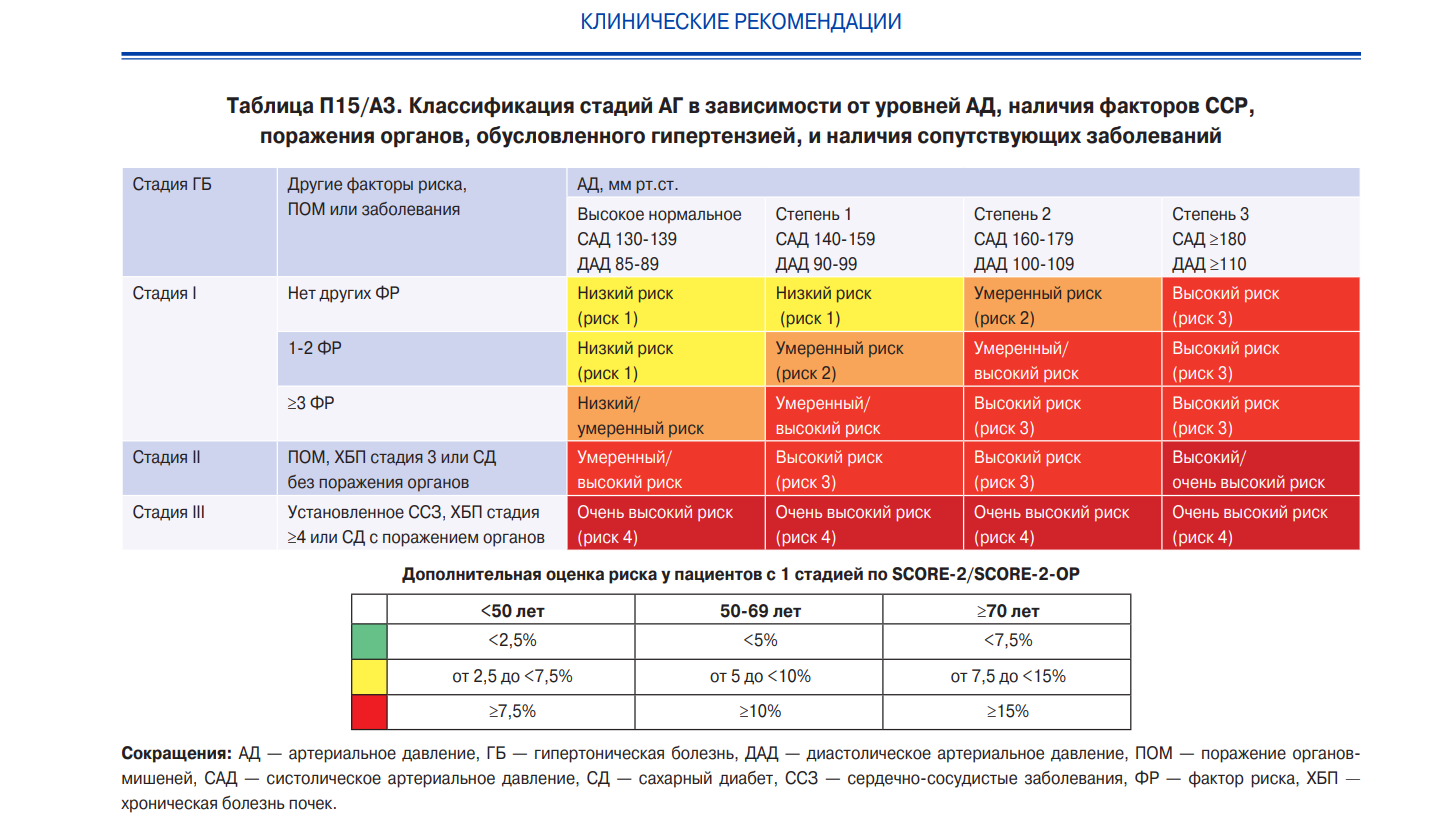

Таким образом по признаку АГ — артериальная гипертензия можно выявлять уровень риска для ССР - сердесно-сосудистых заболеваний
Логичным будет и поделить возраст на группы в соответствии с таблицей Дополнительная оценка риска у пациентов с 1 стадией по SCORE-2/SCORE-2-ОР

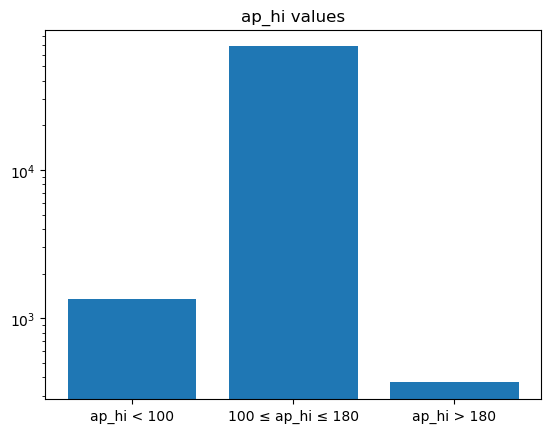

In [588]:
x = ['ap_hi < 100', '100 ≤ ap_hi ≤ 180', 'ap_hi > 180']
y = [sum(df['ap_hi'] < 100), sum((df['ap_hi'] <= 180) & (df['ap_hi'] >= 100)), sum(df['ap_hi'] > 180)]


plt.bar(x, y, log=True, tick_label=x);
plt.title('ap_hi values');

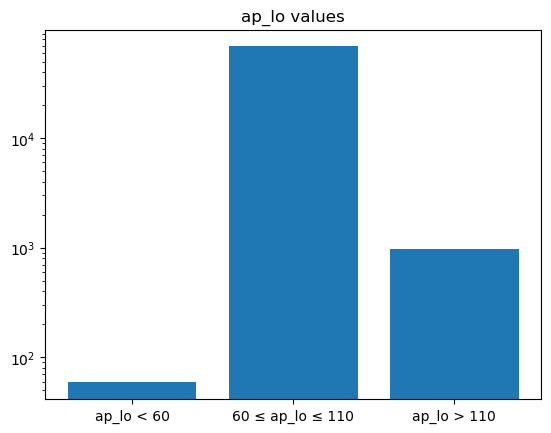

In [589]:
x = ['ap_lo < 60', '60 ≤ ap_lo ≤ 110', 'ap_lo > 110']
y = [sum(df['ap_lo'] < 40), sum((df['ap_lo'] <= 160) & (df['ap_lo'] >= 40)), sum(df['ap_lo'] > 160)]


plt.bar(x, y, log=True, tick_label=x);
plt.title('ap_lo values');

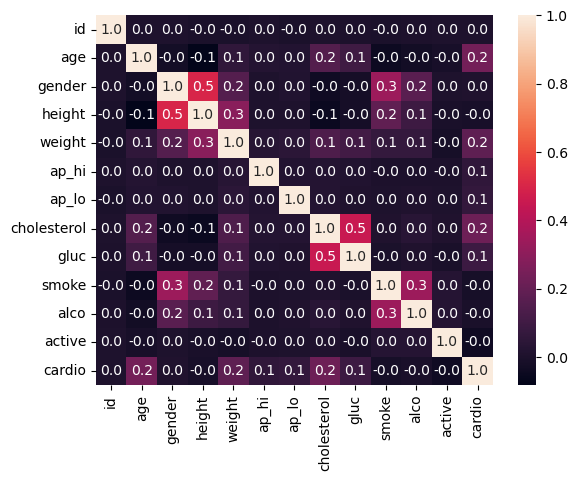

In [590]:
correlation_matrix = df.corr()  # Пирсон

sns.heatmap(correlation_matrix, annot=True, fmt='.1f');

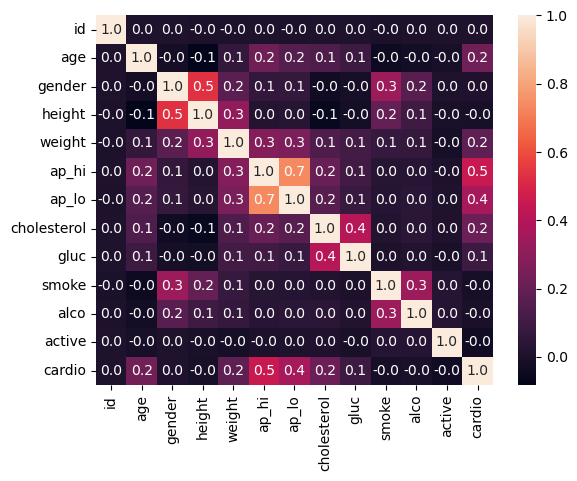

In [591]:
correlation_matrix = df.corr(method='spearman')  # Спирмен

sns.heatmap(correlation_matrix, annot=True, fmt='.1f');

На основе матрицы корреляций можно сделать вывод о том, что с таргетной переменной больше всего коррелируют: ap_hi, ap_lo, cholesterol, weight, age. Но признаки ap_hi и ap_lo имеют между собой высокую корреляцию, что плохо с точки зрения внесения новой информации данными в модель. Поэтому можно либо использовать только 1 из этих признаков, либо их среднее, разность и тд.

### vif

Коэффициент инфляции дисперсии или VIF — это мера, которая помогает обнаружить степень мультиколлинеарности в множественной регрессионной модели. Он показывает, насколько увеличивается дисперсия коэффициента оценки из-за линейной зависимости с другими предикторами.  \
VIF для конкретной независимой переменной рассчитывается по формуле: VIF = 1 / (1 – R²), где R² — коэффициент детерминации, полученный путем регрессии этой независимой переменной против всех других независимых переменных в модели.  \
Как правило, значение VIF от 1 до 5 предполагает умеренную корреляцию, которая не может быть проблематичной, тогда как значение VIF выше 5 указывает на значительную мультиколлинеарность, которая может потребовать дальнейшего исследования. Некоторые аналитики используют пороговое значение 10 в качестве эмпирического правила, предполагая, что любая переменная с VIF выше этого значения должна быть тщательно изучена и потенциально удалена из модели, чтобы повысить надежность регрессионного анализа.

In [592]:
features_vif = pd.DataFrame()
features_vif['fearures'] = df.columns

features_vif['vif'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
features_vif

,fearures,vif
0,id,3.978730
1,age,58.118491
2,gender,11.766925
3,height,102.811065
4,weight,31.875107
5,ap_hi,1.704921
6,ap_lo,1.269905
7,cholesterol,6.710880
8,gluc,7.045671
9,smoke,1.366575


признаки height, weight, age имеют очень высокий vif. Поэтому вместо их использования можно посчитать индекс массы тела, возраст разбить на группы.

## Preprocessing

удалим выбросы в артериальном давлении

In [593]:
df[df['ap_lo'] < 30].shape

(53, 13)

In [594]:
def clean_and_remove_bp(df):
    """Очищает и сразу удаляет некорректные данные АД"""
    
    df = df.copy()
    df['ap_hi'] = pd.to_numeric(df['ap_hi'], errors='coerce')
    df['ap_lo'] = pd.to_numeric(df['ap_lo'], errors='coerce')
    
    
    df['ap_hi'] = df['ap_hi'].abs()
    df['ap_lo'] = df['ap_lo'].abs()
    
    
    hi_large_mask = df['ap_hi'] >= 1000
    lo_large_mask = df['ap_lo'] >= 1000
    
    df.loc[hi_large_mask, 'ap_hi'] = df.loc[hi_large_mask, 'ap_hi'].astype(int).astype(str).str[:3].astype(float)
    df.loc[lo_large_mask, 'ap_lo'] = df.loc[lo_large_mask, 'ap_lo'].astype(int).astype(str).str[:3].astype(float)
    
    
    remove_mask = (
        df['ap_hi'].isna() | df['ap_lo'].isna() |      # пропущенные значения
        (df['ap_hi'] < 50) | (df['ap_hi'] > 300) |     # систолическое вне пределов
        (df['ap_lo'] < 30) | (df['ap_lo'] > 200) |     # диастолическое вне пределов
        (df['ap_hi'] < df['ap_lo']) |                  # систолическое < диастолического
        (df['ap_hi'] >= 1000) | (df['ap_lo'] >= 1000)  
    )
    
    
    return df[~remove_mask].copy()

df = clean_and_remove_bp(df)

df = df[((df['ap_lo'] != 0) & (df['ap_hi'] != 0)) & ((df['ap_lo'] <= 400) & (df['ap_hi'] <= 400))]
display(df.head())
display(df.describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000
mean,49980.163791,19469.964975,1.349505,164.360165,74.212239,127.061890,81.579223,1.367176,1.226270,0.088210,0.053515,0.803770,0.499619
std,28849.557810,2467.347875,0.476817,8.189794,14.402102,17.028622,9.726356,0.680485,0.572003,0.283601,0.225059,0.397148,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,60.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25012.500000,17665.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50006.000000,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74892.500000,21328.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,240.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


удалим колонку id

In [595]:
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

display(df.head())
display(df.shape)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


(69607, 12)

### feature engineering

In [596]:
def age_grouping(age):
    if age < 50:
        return 1
    elif 50 <= age <= 69:
        return 2
    else:
        return 3

def calculate_ag_stage(df):
    """Рассчитывает стадию артериальной гипертензии"""
    if (85 <= df['ap_lo'] <= 89) and (130 <= df['ap_hi'] <= 139):
        return 0
    elif (90 <= df['ap_lo'] <= 99) and (140 <= df['ap_hi'] <= 159):
        return 1
    elif (100 <= df['ap_lo'] <= 109) and (160 <= df['ap_hi'] <= 179):
        return 2
    elif (df['ap_lo'] >= 110) and (df['ap_hi'] >= 180):
        return 3
    else:
        return -1

df['ag_stage'] = df.apply(calculate_ag_stage, axis=1)
        
# индекс массы тела
df['bmi'] = np.round(df['weight'] / (df['height'] / 100) ** 2)

# переводим возраст в года
df['age_years'] = df['age'] // 365
df['age_groups'] = df['age_years'].apply(age_grouping)

display(df.head())
display(df.describe())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ag_stage,bmi,age_years,age_groups
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,-1,22.0,50,2
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,1,35.0,55,2
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,-1,24.0,51,2
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,-1,29.0,48,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,-1,23.0,47,1


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ag_stage,bmi,age_years,age_groups
count,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000,69607.000000
mean,19469.964975,1.349505,164.360165,74.212239,127.061890,81.579223,1.367176,1.226270,0.088210,0.053515,0.803770,0.499619,-0.668381,27.548566,52.843550,1.694241
std,2467.347875,0.476817,8.189794,14.402102,17.028622,9.726356,0.680485,0.572003,0.283601,0.225059,0.397148,0.500003,0.812088,6.071741,6.766926,0.460732
min,10798.000000,1.000000,55.000000,10.000000,60.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,3.000000,29.000000,1.000000
25%,17665.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,24.000000,48.000000,1.000000
50%,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,26.000000,53.000000,2.000000
75%,21328.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,30.000000,58.000000,2.000000
max,23713.000000,2.000000,250.000000,200.000000,240.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000,299.000000,64.000000,2.000000


По данным из журнала [Ожирение и метаболизм](https://www.omet-endojournals.ru/jour/article/view/9629?locale=ru_RU)
Рецензируемый научный медицинский журнал, посвященный проблемам ожирения, метаболических нарушений и эндокринных заболеваний.
<p><strong>Таблица 1. Классификация ожирения по ИМТ (Всемирная организация здравоохранения, 1997 г. с дополнением)</strong></p>
<div class="figure"><div class="table-overflow"><table>
<tbody>
<tr>
<td>
<p>Типы массы тела</p>
</td>
<td>
<p>ИМТ (кг/м2)<br/> Для европеоидной популяции</p>
</td>
<td>
<p>ИМТ (кг/м2)<br/> Для азиатской популяции</p>
</td>
<td>
<p>Риск сопутствующих заболеваний</p>
</td>
</tr>
<tr>
<td>
<p>Нормальная масса тела</p>
</td>
<td>
<p>18,5–24,9</p>
</td>
<td>
<p>18,5–22,9</p>
</td>
<td>
<p>Средний для популяции</p>
</td>
</tr>
<tr>
<td>
<p>Избыточная масса тела</p>
</td>
<td>
<p>25,0–29,9</p>
</td>
<td>
<p>23,0–27,4</p>
</td>
<td>
<p>Повышенный</p>
</td>
</tr>
<tr>
<td>
<p>Ожирение I степени</p>
</td>
<td>
<p>30,0–34,9</p>
</td>
<td>
<p>27,5–32,4</p>
</td>
<td>
<p>Высокий</p>
</td>
</tr>
<tr>
<td>
<p>Ожирение II степени</p>
</td>
<td>
<p>35,0–39,9</p>
</td>
<td>
<p>32,5–37,4</p>
</td>
<td>
<p>Очень высокий</p>
</td>
</tr>
<tr>
<td>
<p>Ожирение III степени</p>
</td>
<td>
<p>Более 40,0</p>
</td>
<td>
<p>Более 37,5</p>
</td>
<td>
<p>Чрезвычайно высокий</p>
</td>
</tr>
</tbody>
</table>

при bmi > 40 наступает ожирение 3 степени. Иметь bmi > 60 практически невозможно

In [597]:
df[df['bmi']>298]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ag_stage,bmi,age_years,age_groups
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,-1,299.0,53,2


In [598]:
df = df[(15 <= df['bmi']) & (df['bmi'] <= 60)]

display(df.head())
display(df.describe())
display(df.shape)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ag_stage,bmi,age_years,age_groups
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,-1,22.0,50,2
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,1,35.0,55,2
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,-1,24.0,51,2
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,-1,29.0,48,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,-1,23.0,47,1


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ag_stage,bmi,age_years,age_groups
count,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000,69531.000000
mean,19469.666997,1.349571,164.406322,74.182893,127.057313,81.576534,1.367289,1.226345,0.088220,0.053501,0.803713,0.499590,-0.668680,27.477413,52.842761,1.694165
std,2467.303371,0.476838,7.947478,14.269789,17.020173,9.723694,0.680587,0.572084,0.283616,0.225033,0.397191,0.500003,0.811647,5.240291,6.766798,0.460763
min,10798.000000,1.000000,100.000000,28.000000,60.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,15.000000,29.000000,1.000000
25%,17664.500000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,24.000000,48.000000,1.000000
50%,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,26.000000,53.000000,2.000000
75%,21328.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,30.000000,58.000000,2.000000
max,23713.000000,2.000000,207.000000,200.000000,240.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,3.000000,60.000000,64.000000,2.000000


(69531, 16)

In [599]:
display(df.head())
display(df['age_groups'].value_counts())

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ag_stage,bmi,age_years,age_groups
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,-1,22.0,50,2
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,1,35.0,55,2
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,-1,24.0,51,2
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,-1,29.0,48,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,-1,23.0,47,1


age_groups
2    48266
1    21265
Name: count, dtype: int64

In [600]:
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df = df[df['pulse_pressure'] > 0] # для vif

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ag_stage,bmi,age_years,age_groups,pulse_pressure
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,-1,22.0,50,2,30
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,1,35.0,55,2,50
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,-1,24.0,51,2,60
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,-1,29.0,48,1,50
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,-1,23.0,47,1,40


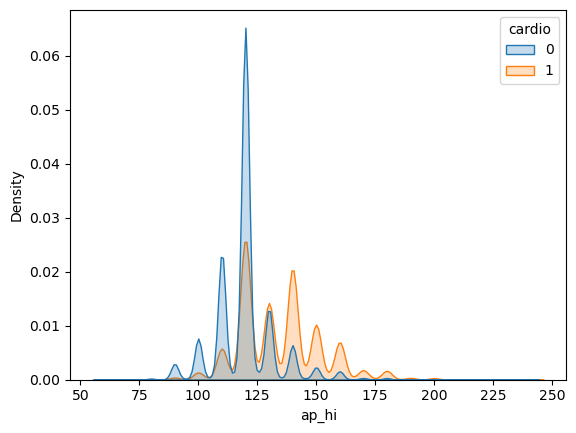

In [601]:
sns.kdeplot(data=df, x='ap_hi', hue='cardio', fill=True);

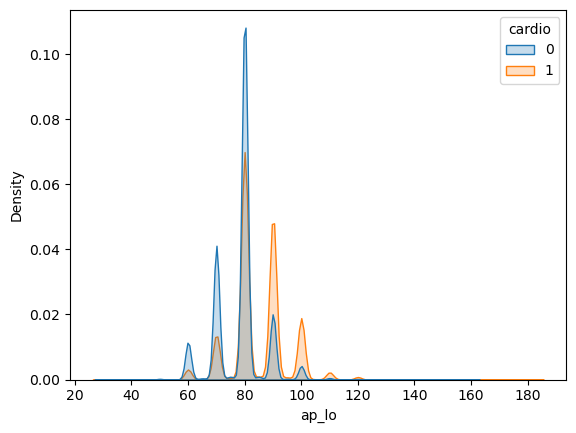

In [602]:
sns.kdeplot(data=df, x='ap_lo', hue='cardio', fill=True);

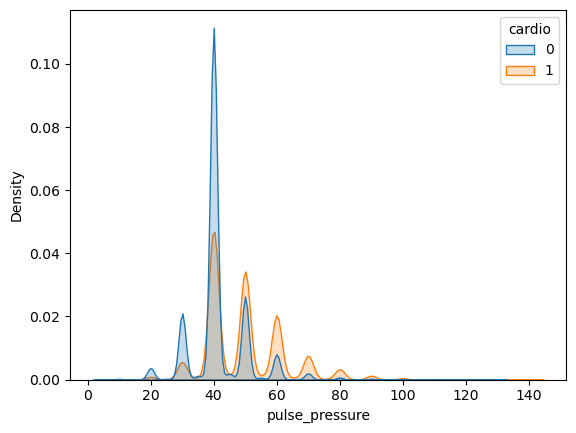

In [603]:
sns.kdeplot(data=df, x='pulse_pressure', hue='cardio', fill=True);

этот признак почти не разделяет данные

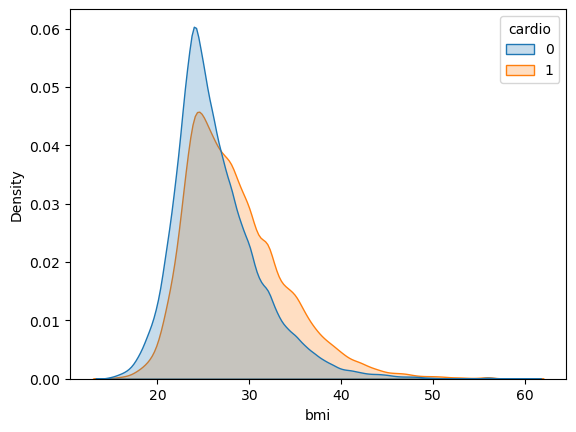

In [604]:
sns.kdeplot(data=df, x='bmi', hue='cardio', fill=True);

у второй группы выше вероятность получить заболевание

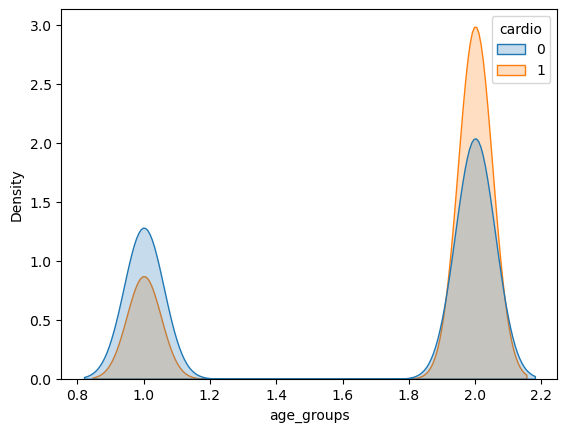

In [605]:
sns.kdeplot(data=df, x='age_groups', hue='cardio', fill=True);

здоровые люди обычно оказываются в группе -1. это информативный признак.

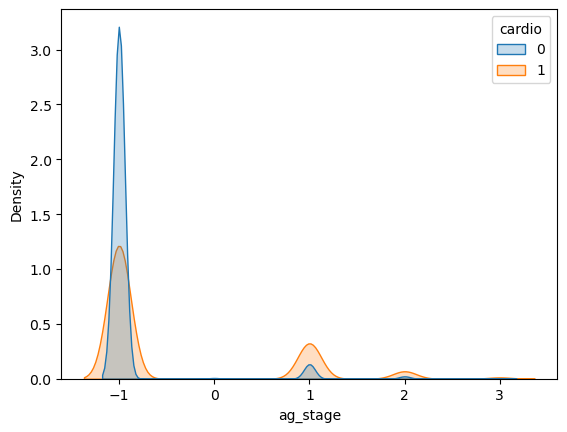

In [606]:
sns.kdeplot(data=df, x='ag_stage', hue='cardio', fill=True);

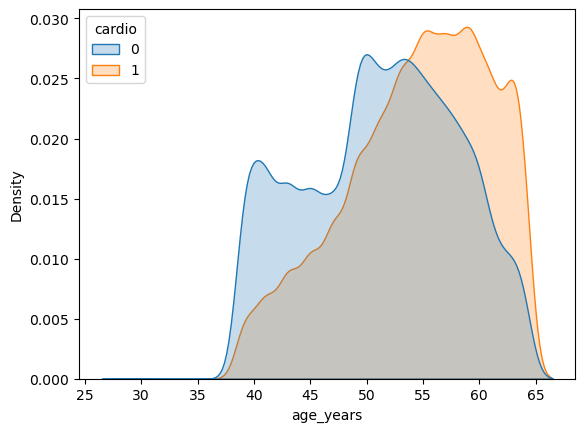

In [607]:
sns.kdeplot(data=df, x='age_years', hue='cardio', fill=True);

пожалуй, пол - это самый бесполезный признак

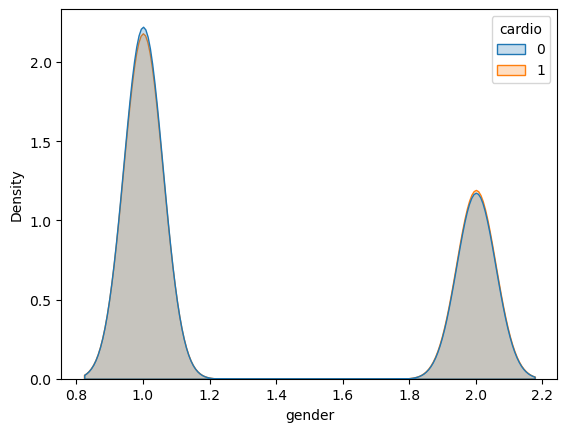

In [608]:
sns.kdeplot(data=df, x='gender', hue='cardio', fill=True);

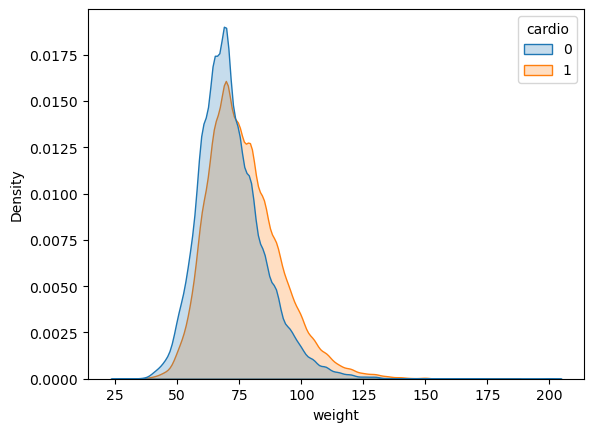

In [609]:
sns.kdeplot(data=df, x='weight', hue='cardio', fill=True);

люди с холестерином 1 чаще оказываются здоровыми

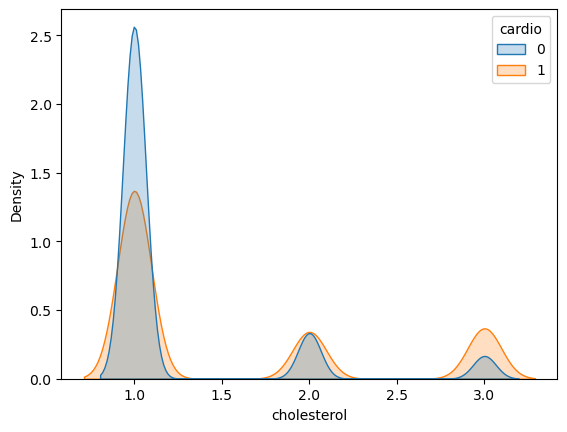

In [610]:
sns.kdeplot(data=df, x='cholesterol', hue='cardio', fill=True);

этот показатель бесполезный

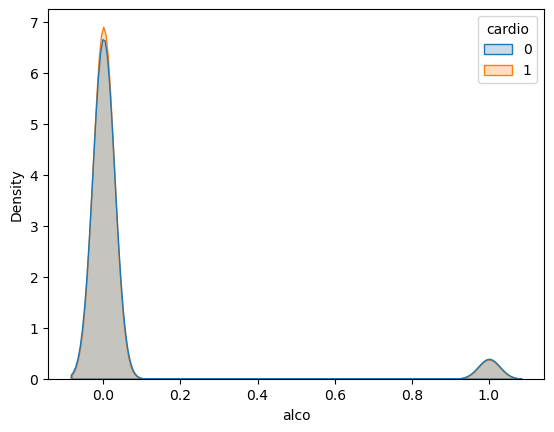

In [611]:
sns.kdeplot(data=df, x='alco', hue='cardio', fill=True);

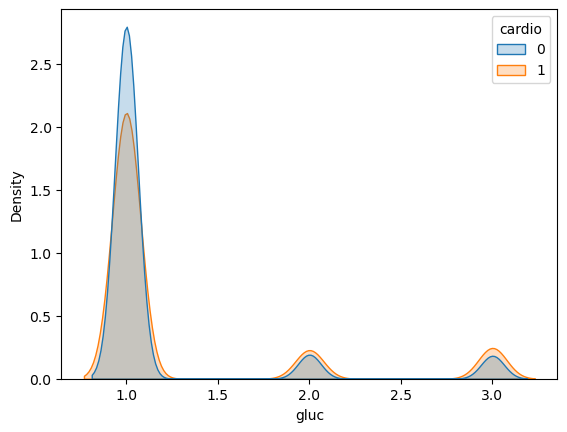

In [612]:
sns.kdeplot(data=df, x='gluc', hue='cardio', fill=True);

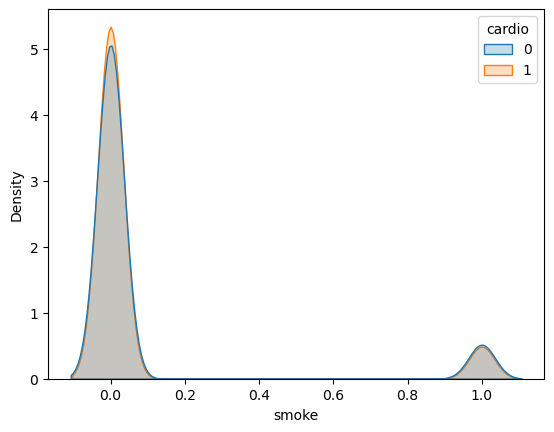

In [613]:
sns.kdeplot(data=df, x='smoke', hue='cardio', fill=True);

неплохо для разделения себя показали: pulse_pressure, age_groups, ag_stage, gluc, cholesterol, age_years, ap_hi, ap_lo

Создадим новый DataFrame с признаками, которые потенциально будут использоваться для обучения модели

In [614]:
data = df[['pulse_pressure', 'age_groups', 'ag_stage', 'gluc', 'cholesterol', 'ap_hi', 'ap_lo', 'cardio']]

data.head()

,pulse_pressure,age_groups,ag_stage,gluc,cholesterol,ap_hi,ap_lo,cardio
0,30,2,-1,1,1,110,80,0
1,50,2,1,1,3,140,90,1
2,60,2,-1,1,3,130,70,1
3,50,1,-1,1,1,150,100,1
4,40,1,-1,1,1,100,60,0


In [615]:
df[df['cholesterol'] == 0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ag_stage,bmi,age_years,age_groups,pulse_pressure


In [616]:
features_vif = pd.DataFrame()
features_vif['fearures'] = data.columns

features_vif['vif'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
features_vif

C:\Users\Matvey\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,fearures,vif
0,pulse_pressure,inf
1,age_groups,14.559200
2,ag_stage,1.689731
3,gluc,6.958905
4,cholesterol,6.683027
5,ap_hi,inf
6,ap_lo,inf
7,cardio,2.419821


на ячейке ниже оптимальный выбор параметров. Мультиколлинеарность стала меньше, корреляция с таргетом хорошая.

In [617]:
data = df[['age_groups', 'ag_stage', 'gluc', 'cholesterol', 'ap_hi', 'cardio']]

display(data.head())

features_vif = pd.DataFrame()
features_vif['fearures'] = data.columns

features_vif['vif'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
features_vif

,age_groups,ag_stage,gluc,cholesterol,ap_hi,cardio
0,2,-1,1,1,110,0
1,2,1,1,3,140,1
2,2,-1,1,3,130,1
3,1,-1,1,1,150,1
4,1,-1,1,1,100,0


,fearures,vif
0,age_groups,14.317597
1,ag_stage,1.669518
2,gluc,6.941062
3,cholesterol,6.678745
4,ap_hi,18.332485
5,cardio,2.398766


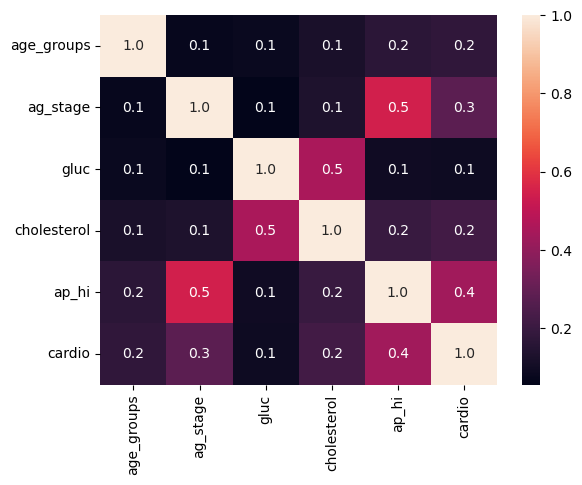

In [618]:
correlation_matrix = data.corr()  # Пирсон

sns.heatmap(correlation_matrix, annot=True, fmt='.1f');

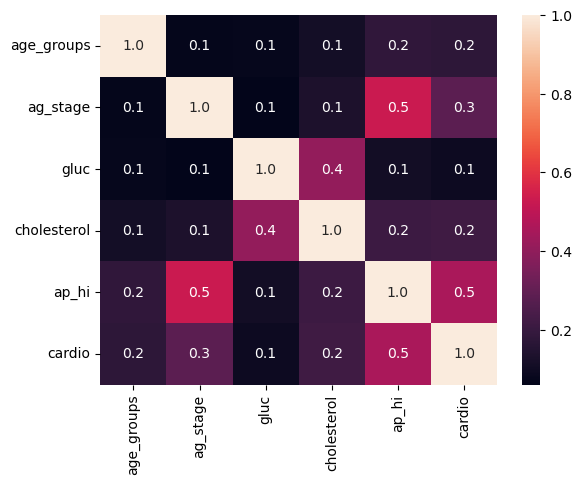

In [619]:
correlation_matrix = data.corr(method='spearman')  # Спирмен

sns.heatmap(correlation_matrix, annot=True, fmt='.1f');

In [620]:
if os.path.exists('./dataset/data_cleaning.csv'):
    print('Файл уже существует')
else:
    data.to_csv('./dataset/data_cleaning.csv', index=False)